# RNN model for LoL headhunting
Goal: develop a model which predicts if a player will be promoted to play in the major league upcoming 10 years, based on their playing style in the first year they start playing in the upper leagues .

## Import packages

In [1]:
#import packages
import pandas as pd
import numpy as np
from datetime import date
from sklearn import set_config;
set_config(display='diagram')
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline, make_union
from sklearn.compose import make_column_transformer, make_column_selector
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from tensorflow.keras.preprocessing.sequence import pad_sequences
from collections import Counter
from imblearn.over_sampling import RandomOverSampler
import seaborn as sns
import matplotlib.pyplot as plt 

## Import data

In [2]:
df = pd.read_csv("~/code/akahrs/LoL-Final-Project/predictleague/predictleague/data/df_cleaned_final3.csv")
df.head()

,Unnamed: 0,Unnamed: 0.1,league,year,position,playername,teamname,gamelength,result,kills,...,goldat15,xpat15,csat15,golddiffat15,xpdiffat15,csdiffat15,killsat15,assistsat15,deathsat15,target
0,506,506,NA CS,2014,top,Yazuki,Cloud9 Tempest,2513,0,2,...,4895.0,7512.0,128.0,860.0,1043.0,29.0,0.0,1.0,0.0,1
1,507,507,NA CS,2014,jng,Kez,Cloud9 Tempest,2513,0,5,...,3680.0,5423.0,65.0,-243.0,-610.0,-8.0,0.0,1.0,0.0,1
2,508,508,NA CS,2014,mid,Bischu,Cloud9 Tempest,2513,0,1,...,4411.0,6694.0,102.0,124.0,79.0,-14.0,1.0,0.0,0.0,1
3,509,509,NA CS,2014,bot,Altec,Cloud9 Tempest,2513,0,1,...,4743.0,4312.0,125.0,880.0,131.0,34.0,0.0,1.0,0.0,1
4,510,510,NA CS,2014,sup,Gleeb,Cloud9 Tempest,2513,0,1,...,3013.0,4106.0,1.0,370.0,638.0,0.0,1.0,0.0,0.0,1


### Preprocessing duplicates, columns, nan target

In [3]:
# drop rows with X as target
df = df.loc[df['target'] != 'x', :]

# drop duplicates
df = df.drop_duplicates()

# drop not needed columns
df = df.drop(columns=['goldat10','xpat10', 'csat10', 'golddiffat10', 'xpdiffat10','csdiffat10','killsat10','assistsat10','deathsat10','goldat15','xpat15','csat15','golddiffat15','xpdiffat15','csdiffat15','killsat15','assistsat15','deathsat15','doublekills', 'triplekills', 'quadrakills', 'pentakills', 'firstbloodkill', 'firstbloodassist', 'firstbloodvictim', 'controlwardsbought', 'earnedgoldshare'])

#create kills_assists_deaths metric
df['deaths2'] = df['deaths'].map(lambda x: 1 if x == 0 else x)
df['kills_assists_deaths_metric']=(df['kills']+df['assists'])/df['deaths2']

df = df.drop(columns=['kills','deaths','assists','Unnamed: 0'])

# drop rows where target is nan
df = df.dropna(subset=["target"])

#drop rows with negative values for earned gpm
df = df.drop(df.index[df['earned gpm'] < 0])

#drop rows with dpm values above 3000
df = df.drop(df.index[df['dpm'] > 3000])

#drop rows where year is in the future
df = df.drop(df.index[df['year'] > date.today().year])


In [4]:
#drop all games of people that did not play at least 1 game in the best leagues
bestleagues = ["EU LCS", "NA LCS", "LMS", "LEC", "LCS", "LCK", "LPL", "PCS", "NA CS", "EU CS", "KeSPA", "LSPL", "LCK CL", "DC", "NASG", "Proving Grounds Circuit", "LVP DDH", "LFL", "LDL", "GPL", "EM", "LCSA"]

keep_list = []
for person in df['playername'].unique():
    #put person on keep_list if at least one of his matches was in the bestleagues 
    if len(df.loc[df['playername']==person,['league']][df['league'].isin(bestleagues)]) > 0:
        keep_list.append(person)
        
df = df[df.playername.isin(keep_list) == True]

/var/folders/d9/88yhzft11312hl2s94b0tlgr0000gn/T/ipykernel_49171/3906016313.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if len(df.loc[df['playername']==person,['league']][df['league'].isin(bestleagues)]) > 0:


In [5]:
#save df in CSV, such that it can be checked
df.to_csv("~/code/akahrs/LoL-Final-Project/predict_league/df_onlybestleagues2.csv")

### Explore the data

In [6]:
df.head(5)

,Unnamed: 0.1,league,year,position,playername,teamname,gamelength,result,damagetochampions,dpm,...,wpm,wcpm,vspm,earned gpm,cspm,monsterkillsownjungle,monsterkillsenemyjungle,target,deaths2,kills_assists_deaths_metric
0,506,NA CS,2014,top,Yazuki,Cloud9 Tempest,2513,0,17745.0,423.6769,...,0.3581,0.0000,0.0,194.9940,7.5686,21.0,9.0,1,2,3.50
1,507,NA CS,2014,jng,Kez,Cloud9 Tempest,2513,0,9238.0,220.5651,...,0.5014,0.1910,0.0,148.0780,3.3187,93.0,7.0,1,3,2.00
2,508,NA CS,2014,mid,Bischu,Cloud9 Tempest,2513,0,17560.0,419.2598,...,0.4298,0.0716,0.0,162.0454,6.2555,34.0,5.0,1,5,1.40
3,509,NA CS,2014,bot,Altec,Cloud9 Tempest,2513,0,12578.0,300.3104,...,0.1910,0.1910,0.0,187.3776,6.9240,17.0,1.0,1,4,1.75
4,510,NA CS,2014,sup,Gleeb,Cloud9 Tempest,2513,0,7737.0,184.7274,...,1.2654,0.1671,0.0,89.7493,0.2149,0.0,0.0,1,2,4.00


In [7]:
df.describe()

,Unnamed: 0.1,year,gamelength,result,damagetochampions,dpm,damageshare,damagetakenperminute,damagemitigatedperminute,wpm,wcpm,vspm,earned gpm,cspm,monsterkillsownjungle,monsterkillsenemyjungle,target,deaths2,kills_assists_deaths_metric
count,189357.000000,189357.000000,189357.000000,189357.000000,189357.000000,189357.000000,189357.000000,189357.000000,137906.000000,189357.000000,189357.000000,131181.000000,189357.000000,189357.000000,152670.000000,152670.000000,189357.000000,189357.000000,189357.000000
mean,469378.461441,2019.811789,1925.282958,0.494632,12870.268762,396.067957,0.199617,572.086037,462.737699,0.627521,0.264037,1.276689,227.195001,6.334379,25.272293,4.502044,0.393674,2.943810,5.014528
std,249920.597971,1.952743,368.999688,0.499973,8161.473970,219.209751,0.094731,232.514819,322.787289,0.448590,0.160898,0.756950,82.795912,3.056220,35.254750,8.510938,0.488565,1.811302,4.815033
min,506.000000,2014.000000,938.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.051500,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
25%,252760.000000,2019.000000,1663.000000,0.000000,6760.000000,221.214800,0.121579,393.068700,236.915275,0.342300,0.144700,0.835700,167.864800,4.558800,0.000000,0.000000,0.000000,1.000000,1.333333
50%,484595.000000,2020.000000,1880.000000,0.000000,11294.000000,367.264700,0.197446,530.900600,401.664550,0.449000,0.238000,1.137000,228.374600,7.205500,9.000000,0.000000,0.000000,3.000000,3.000000
75%,691368.000000,2021.000000,2131.000000,1.000000,17039.000000,529.801700,0.266258,732.000000,635.962775,0.740200,0.356600,1.614500,285.926400,8.662100,28.000000,5.000000,1.000000,4.000000,7.500000
max,864491.000000,2022.000000,5341.000000,1.000000,150341.000000,2293.531700,0.641525,2026.819200,3442.544700,3.561600,1.601800,6.244800,612.331000,14.760000,210.000000,130.000000,1.000000,15.000000,33.000000


In [8]:
#total amount of players
print("total amount of players :")
print(len(df['playername'].unique()))

#which % of people went to the upper league? Check to know if oversampling is needed.
print("target % (percentage of people that went to the upper league):") 
print(df['target'].sum()/len(df['playername'].unique()))

total amount of players :
3092
target % (percentage of people that went to the upper league):
24.108990944372575


/Users/nienkepieters/.pyenv/versions/3.8.12/envs/lewagon/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/Users/nienkepieters/.pyenv/versions/3.8.12/envs/lewagon/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/Users/nienkepieters/.pyenv/versions/3.8.12/envs/lewagon/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other argume

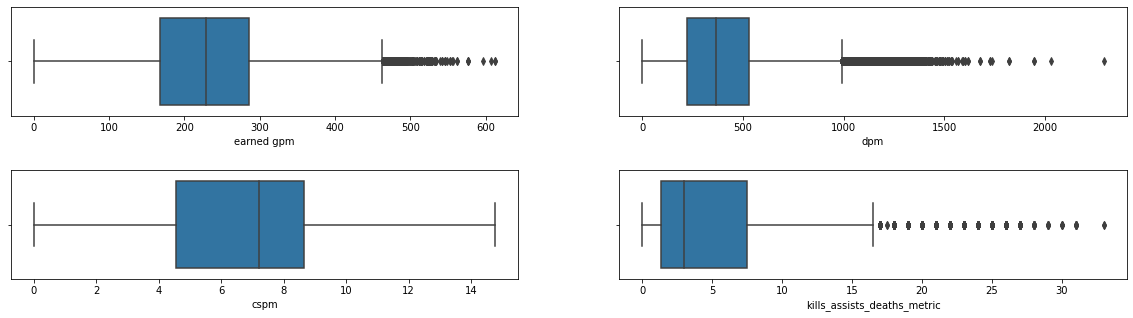

In [9]:
fig = plt.figure(figsize = (20,5))
fig.subplots_adjust(hspace=0.5, wspace=0.2)
ax = fig.add_subplot(2, 2, 1)
sns.boxplot(df['earned gpm'], ax=ax)
ax = fig.add_subplot(2, 2, 2)
sns.boxplot(df['dpm'], ax=ax)
ax = fig.add_subplot(2, 2, 3)
sns.boxplot(df['cspm'], ax=ax)
ax = fig.add_subplot(2, 2, 4)
sns.boxplot(df['kills_assists_deaths_metric'], ax=ax)

plt.show()

In [10]:
df.head(5)

,Unnamed: 0.1,league,year,position,playername,teamname,gamelength,result,damagetochampions,dpm,...,wpm,wcpm,vspm,earned gpm,cspm,monsterkillsownjungle,monsterkillsenemyjungle,target,deaths2,kills_assists_deaths_metric
0,506,NA CS,2014,top,Yazuki,Cloud9 Tempest,2513,0,17745.0,423.6769,...,0.3581,0.0000,0.0,194.9940,7.5686,21.0,9.0,1,2,3.50
1,507,NA CS,2014,jng,Kez,Cloud9 Tempest,2513,0,9238.0,220.5651,...,0.5014,0.1910,0.0,148.0780,3.3187,93.0,7.0,1,3,2.00
2,508,NA CS,2014,mid,Bischu,Cloud9 Tempest,2513,0,17560.0,419.2598,...,0.4298,0.0716,0.0,162.0454,6.2555,34.0,5.0,1,5,1.40
3,509,NA CS,2014,bot,Altec,Cloud9 Tempest,2513,0,12578.0,300.3104,...,0.1910,0.1910,0.0,187.3776,6.9240,17.0,1.0,1,4,1.75
4,510,NA CS,2014,sup,Gleeb,Cloud9 Tempest,2513,0,7737.0,184.7274,...,1.2654,0.1671,0.0,89.7493,0.2149,0.0,0.0,1,2,4.00


## Preprocess data

### Functions for preprocessing

In [11]:
def create_train_test_tensors(df):
    ''' This function creates train and test sets (30% = test set). It contains tensors with the matches of the first year of each player.'''
    
    # list the first year each player is active in a df
    name_year_list = df[['playername','year','target']].groupby(by="playername").min()
    name_year_list = name_year_list.reset_index()
    
    #create tensor with matches for first year of each player
    tensor = []
    #features = ['earned gpm', 'dpm', 'cspm', 'kills_assists_deaths_metric', 'result','playername','target']
    features = ['result','playername','target']
    for index, row in name_year_list.iterrows():
        tensor.append(df.loc[(df['playername']==row['playername'])&(df['year']==row['year']), features])
        
    # Create X and y
    X = np.array(tensor, dtype=object)
    y = name_year_list['target'].astype('int32')
    
    #split train and test set
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)
    
    return X_train, X_test, y_train, y_test

In [12]:
def preprocess_data(X_train, X_test):
    ''' This function scales the data. It has to untensor and then tensor again the data to be able to do this. 
    Then it will pad the train and test data, such that each tensor has the same length'''
    
    #untensor train and test data. Create long list of all matches. This has to be done for the scaling.
    X_train_untensored = pd.DataFrame()
    for player in range(len(X_train)):
        X_train_untensored = pd.concat([X_train_untensored, X_train[player]])
        
    X_test_untensored = pd.DataFrame()
    for player in range(len(X_test)):
        X_test_untensored = pd.concat([X_test_untensored, X_test[player]])
    
    #create preprocessing pipeline for Imputing then scaling numerical values: 
    num_transformer = make_pipeline(SimpleImputer(), StandardScaler())
    preprocessing = make_column_transformer(
        #(num_transformer, ['earned gpm', 'dpm', 'cspm', 'kills_assists_deaths_metric', 'result']),
        (num_transformer, ['result']),
        #(cat_transformer, cat_col),
        remainder='passthrough')
    
    # fit & scale train data. Only scale test data.
    X_train_transformed = pd.DataFrame(preprocessing.fit_transform(X_train_untensored))
    X_test_transformed = pd.DataFrame(preprocessing.transform(X_test_untensored))
    
    #make tensor again for train and test data
    features = [0]

    unique_players_train = X_train_transformed[1].unique()
    X_train_tensor = []
    for name in unique_players_train:
        X_train_tensor.append(X_train_transformed.loc[(X_train_transformed[1]==name), features])
        
    unique_players_test = X_test_transformed[1].unique()
    X_test_tensor = []
    for name in unique_players_test:
        X_test_tensor.append(X_test_transformed.loc[(X_test_transformed[1]==name), features])
        
    # Padding train and test data
    X_train_preprocessed = pad_sequences(np.array(X_train_tensor, dtype=object), dtype='float32', padding = 'post', value=-1000, maxlen=150) # int32 by default
    X_test_preprocessed = pad_sequences(np.array(X_test_tensor, dtype=object), dtype='float32', padding = 'post', value=-1000, maxlen=150) # int32 by default
    
    return X_train_preprocessed, X_test_preprocessed

In [13]:
def oversample_train_data(X_train_preprocessed, y_train):
    ''' This function oversamples train data - can be called if needed'''

    # define oversampling strategy
    oversample = RandomOverSampler(sampling_strategy=0.3)
    
    (a,b,c) = X_train_preprocessed.shape

    #shape and reshape
    X_train_reshape = X_train_preprocessed.reshape(a, b * c)
    
    # fit and apply the transform
    X_train_over, y_train_over = oversample.fit_resample(X_train_reshape, y_train)
    (d,e) = X_train_over.shape
    
    X_train_over = X_train_over.reshape(d, b, c)
    
    return X_train_over, y_train_over

### Preprocess data
Oversampling is not needed, as 25% of the target is a 1 (25% of people went to play in the major league, 75% did not).

In [14]:
#create X and y data
X_all_train, X_all_test, y_all_train, y_all_test = create_train_test_tensors(df)

#preprocess X_train and X_test
X_all_train_preprocessed, X_all_test_preprocessed = preprocess_data(X_all_train, X_all_test)
print(f"Shape of preprocessed X_train and X_test data for all players:")
print(X_all_train_preprocessed.shape, X_all_test_preprocessed.shape)

#oversample train data ---> not needed as about 25% of the target is a hit
#X_all_train_over, y_all_train_over = oversample_train_data(X_all_train_preprocessed, y_all_train)
#print(f"\n Shape of oversampled X_train and y_train data for all players:")
#print(X_all_train_over.shape, y_all_train_over.shape)

Shape of preprocessed X_train and X_test data for all players:
(2164, 150, 1) (928, 150, 1)


## RNN model

### Fitting the model

In [19]:
from tensorflow.keras import layers, regularizers
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.metrics import Precision, Recall

es = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)
reg_l2 = regularizers.L2(0.02)

(a,b,c) = X_all_train_preprocessed.shape

# –– Model
model = Sequential()
model.add(layers.Masking(mask_value=-1000, input_shape=(b, c)))
model.add(layers.LSTM(units=10, activation='tanh', recurrent_dropout=0.3)) #LSTM (recurrent or dropout) or GRU, tanh as activation
#model.add(layers.SimpleRNN(2, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

# –– Compilation
model.compile(loss='binary_crossentropy', 
              optimizer='adam',
              metrics=['accuracy','Precision','Recall'])

# –– Fit
history = model.fit(X_all_train_preprocessed, y_all_train, 
          epochs=100, 
          validation_split = 0.3,
          callbacks=[es]); #check if we can make the early stopping on the f1-metric of the validation -> monitor?


2022-10-15 14:03:49.973059: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Epoch 1/100
48/48 [==============================] - 9s 131ms/step - loss: 0.6335 - accuracy: 0.6816 - precision: 0.5367 - recall: 0.2349 - val_loss: 0.6053 - val_accuracy: 0.6846 - val_precision: 0.6667 - val_recall: 0.1448
Epoch 2/100
48/48 [==============================] - 6s 115ms/step - loss: 0.6002 - accuracy: 0.6830 - precision: 0.5682 - recall: 0.1506 - val_loss: 0.5856 - val_accuracy: 0.6831 - val_precision: 0.6923 - val_recall: 0.1222
Epoch 3/100
48/48 [==============================] - 6s 117ms/step - loss: 0.5936 - accuracy: 0.6869 - precision: 0.5811 - recall: 0.1727 - val_loss: 0.5785 - val_accuracy: 0.6892 - val_precision: 0.6939 - val_recall: 0.1538
Epoch 4/100
48/48 [==============================] - 6s 119ms/step - loss: 0.5912 - accuracy: 0.6915 - precision: 0.5963 - recall: 0.1928 - val_loss: 0.5748 - val_accuracy: 0.6969 - val_precision: 0.7000 - val_recall: 0.1900
Epoch 5/100
48/48 [==============================] - 6s 126ms/step - loss: 0.5870 - accuracy: 0.6962

48/48 [==============================] - 6s 115ms/step - loss: 0.5653 - accuracy: 0.7133 - precision: 0.6067 - recall: 0.3655 - val_loss: 0.5514 - val_accuracy: 0.7415 - val_precision: 0.7227 - val_recall: 0.3891
Epoch 38/100
48/48 [==============================] - 6s 117ms/step - loss: 0.5672 - accuracy: 0.7041 - precision: 0.5880 - recall: 0.3353 - val_loss: 0.5497 - val_accuracy: 0.7477 - val_precision: 0.7355 - val_recall: 0.4027
Epoch 39/100
48/48 [==============================] - 6s 121ms/step - loss: 0.5595 - accuracy: 0.7153 - precision: 0.6091 - recall: 0.3755 - val_loss: 0.5487 - val_accuracy: 0.7462 - val_precision: 0.7295 - val_recall: 0.4027
Epoch 40/100
48/48 [==============================] - 6s 121ms/step - loss: 0.5617 - accuracy: 0.7107 - precision: 0.5949 - recall: 0.3775 - val_loss: 0.5490 - val_accuracy: 0.7477 - val_precision: 0.7664 - val_recall: 0.3710
Epoch 41/100
48/48 [==============================] - 6s 126ms/step - loss: 0.5655 - accuracy: 0.7120 - preci

48/48 [==============================] - 5s 114ms/step - loss: 0.5493 - accuracy: 0.7147 - precision: 0.6038 - recall: 0.3855 - val_loss: 0.5361 - val_accuracy: 0.7446 - val_precision: 0.7068 - val_recall: 0.4253
Epoch 74/100
48/48 [==============================] - 5s 115ms/step - loss: 0.5567 - accuracy: 0.7127 - precision: 0.5994 - recall: 0.3815 - val_loss: 0.5360 - val_accuracy: 0.7508 - val_precision: 0.7360 - val_recall: 0.4163
Epoch 75/100
48/48 [==============================] - 5s 114ms/step - loss: 0.5536 - accuracy: 0.7160 - precision: 0.6037 - recall: 0.3976 - val_loss: 0.5349 - val_accuracy: 0.7508 - val_precision: 0.7218 - val_recall: 0.4344
Epoch 76/100
48/48 [==============================] - 5s 114ms/step - loss: 0.5470 - accuracy: 0.7252 - precision: 0.6265 - recall: 0.4076 - val_loss: 0.5349 - val_accuracy: 0.7492 - val_precision: 0.7164 - val_recall: 0.4344
Epoch 77/100
48/48 [==============================] - 5s 113ms/step - loss: 0.5527 - accuracy: 0.7186 - preci

## Results & Evaluation

In [20]:
#Evaluate model
model.evaluate(X_all_test_preprocessed,y_all_test)

29/29 [==============================] - 1s 15ms/step - loss: 0.5077 - accuracy: 0.7511 - precision: 0.6537 - recall: 0.4558


[0.5076502561569214,
 0.7510775923728943,
 0.6536585092544556,
 0.45578232407569885]

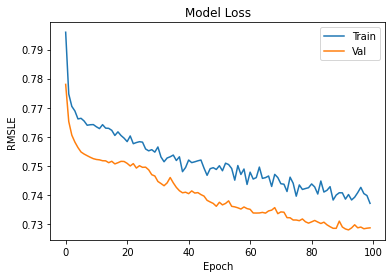

In [21]:
#Plot model loss

def plot_history(history):
    plt.plot(np.sqrt(history.history['loss']))
    plt.plot(np.sqrt(history.history['val_loss']))
    plt.title('Model Loss')
    plt.ylabel('RMSLE')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Val'], loc='best')
    plt.show()
    
plot_history(history)

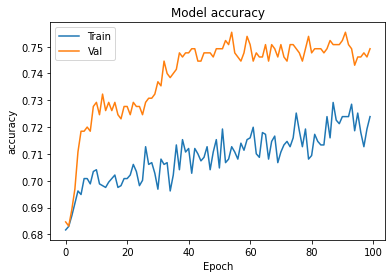

In [22]:
#Plot Accuracy

def plot_history3(history):
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Val'], loc='best')
    plt.show()
    
plot_history3(history)

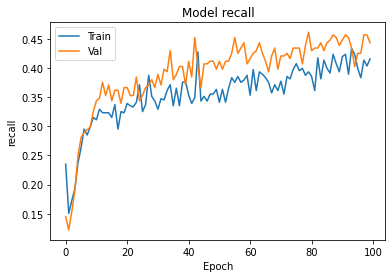

In [23]:
#Plot Recall

def plot_history4(history):
    plt.plot(history.history['recall'])
    plt.plot(history.history['val_recall'])
    plt.title('Model recall')
    plt.ylabel('recall')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Val'], loc='best')
    plt.show()
    
plot_history4(history)

## Save model to put in production

In [24]:
#the model is saved, such that it can be used in production
model.save('my_model2.h5')

# DataFrames for specific player positions

As there are 5 player positions (top, jng, mid, bot and sup) in each team which each have their own goals and powers during a match, it is also possible to create a separate model for each specific player type. In this part, 5 different dataframes are created which can be used for this purpose.

### Split df per position (top, jng, mid, bot, sup) and keep only relevant features

In [25]:
columns = ['year','playername','position','earned gpm', 'dpm', 'cspm', 'kills_assists_deaths_metric', 'result','target']

#create df per position
df_top = df.loc[df['position']=='top',columns]
df_jng = df.loc[df['position']=='jng',columns]
df_mid = df.loc[df['position']=='mid',columns]
df_bot = df.loc[df['position']=='bot',columns]
df_sup = df.loc[df['position']=='sup',columns]

#show final df for top-position players
df_top.head(5)

,year,playername,position,earned gpm,dpm,cspm,kills_assists_deaths_metric,result,target
0,2014,Yazuki,top,194.9940,423.6769,7.5686,3.500000,0,1
5,2014,Jezie,top,245.9212,290.7123,6.6375,5.333333,1,0
11,2014,Jezie,top,183.3990,463.0260,5.3413,2.500000,1,0
17,2014,Yazuki,top,241.1823,687.1499,7.7692,10.000000,0,1
22,2014,Sphinx,top,186.3969,466.1892,6.9874,1.000000,0,0


### 1. Process data for "top" players

In [26]:
#create X and y data
X_top_train, X_top_test, y_top_train, y_top_test = create_train_test_tensors(df_top)

#preprocess X_train and X_test
X_top_train_preprocessed, X_top_test_preprocessed = preprocess_data(X_top_train, X_top_test)
print(f"Shape of preprocessed X_train and X_test data for 'top' players:")
print(X_top_train_preprocessed.shape, X_top_test_preprocessed.shape)

#oversample train data
#X_top_train_over, y_top_train_over = oversample_train_data(X_top_train_preprocessed, y_top_train)
#print(f"\n Shape of oversampled X_train and y_train data for 'top' players:")
#print(X_top_train_over.shape, y_top_train_over.shape)

Shape of preprocessed X_train and X_test data for 'top' players:
(471, 150, 1) (203, 150, 1)


### 2. Process data for "jng" players

In [27]:
#create X and y data
X_jng_train, X_jng_test, y_jng_train, y_jng_test = create_train_test_tensors(df_jng)

#preprocess X_train and X_test
X_jng_train_preprocessed, X_jng_test_preprocessed = preprocess_data(X_jng_train, X_jng_test)
print(f"Shape of preprocessed X_train and X_test data for 'jng' players:")
print(X_jng_train_preprocessed.shape, X_jng_test_preprocessed.shape)

#oversample train data
#X_jng_train_over, y_jng_train_over = oversample_train_data(X_jng_train_preprocessed, y_jng_train)
#print(f"\n Shape of oversampled X_train and y_train data for 'top' players:")
#print(X_jng_train_over.shape, y_jng_train_over.shape)

Shape of preprocessed X_train and X_test data for 'jng' players:
(534, 150, 1) (229, 150, 1)


### 3. Process data for "mid" players

In [28]:
#create X and y data
X_mid_train, X_mid_test, y_mid_train, y_mid_test = create_train_test_tensors(df_mid)

#preprocess X_train and X_test
X_mid_train_preprocessed, X_mid_test_preprocessed = preprocess_data(X_mid_train, X_mid_test)
print(f"Shape of preprocessed X_train and X_test data for 'mid' players:")
print(X_mid_train_preprocessed.shape, X_mid_test_preprocessed.shape)

#oversample train data
#X_mid_train_over, y_mid_train_over = oversample_train_data(X_mid_train_preprocessed, y_mid_train)
#print(f"\n Shape of oversampled X_train and y_train data for 'mid' players:")
#print(X_mid_train_over.shape, y_mid_train_over.shape)

Shape of preprocessed X_train and X_test data for 'mid' players:
(485, 150, 1) (209, 150, 1)


### 4. Process data for "bot" players

In [29]:

#create X and y data
X_bot_train, X_bot_test, y_bot_train, y_bot_test = create_train_test_tensors(df_bot)

#preprocess X_train and X_test
X_bot_train_preprocessed, X_bot_test_preprocessed = preprocess_data(X_bot_train, X_bot_test)
print(f"Shape of preprocessed X_train and X_test data for 'bot' players:")
print(X_bot_train_preprocessed.shape, X_bot_test_preprocessed.shape)

#oversample train data
#X_bot_train_over, y_bot_train_over = oversample_train_data(X_bot_train_preprocessed, y_bot_train)
#print(f"\n Shape of oversampled X_train and y_train data for 'bot' players:")
#print(X_bot_train_over.shape, y_bot_train_over.shape)

Shape of preprocessed X_train and X_test data for 'bot' players:
(487, 150, 1) (209, 150, 1)


### 5. Process data for "sup" players

In [30]:
#create X and y data
X_sup_train, X_sup_test, y_sup_train, y_sup_test = create_train_test_tensors(df_sup)

#preprocess X_train and X_test
X_sup_train_preprocessed, X_sup_test_preprocessed = preprocess_data(X_sup_train, X_sup_test)
print(f"Shape of preprocessed X_train and X_test data for 'sup' players:")
print(X_sup_train_preprocessed.shape, X_sup_test_preprocessed.shape)

#oversample train data
#X_sup_train_over, y_sup_train_over = oversample_train_data(X_sup_train_preprocessed, y_sup_train)
#print(f"\n Shape of oversampled X_test and y_test data for 'sup' players:")
#print(X_sup_train_over.shape, y_sup_train_over.shape)

Shape of preprocessed X_train and X_test data for 'sup' players:
(501, 150, 1) (215, 150, 1)
